In [1]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

from pandas.plotting import scatter_matrix

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor






In [5]:
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

songs_df.head()

,Unnamed: 0,Artist,Track Name,Track ID,Popularity,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Valence
0,0,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,90,0.55600,0.760,158040,0.479,0.000000,2,0.0703,-5.574,1,0.0466,89.911,4,0.913
1,1,Lil Baby,Drip Too Hard (Lil Baby & Gunna),78QR3Wp35dqAhFEc2qAGjE,86,0.08520,0.897,145543,0.662,0.000000,1,0.5340,-6.903,0,0.2920,112.511,4,0.389
2,2,Travis Scott,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,89,0.00513,0.834,312820,0.730,0.000000,8,0.1240,-3.714,1,0.2220,155.008,4,0.446
3,3,Juice WRLD,Lucid Dreams,285pBltuF7vW8TeWk8hdRR,88,0.34900,0.511,239836,0.566,0.000000,6,0.3400,-7.230,0,0.2000,83.903,4,0.218
4,4,YNW Melly,Murder On My Mind,7eBqSVxrzQZtK2mmgRG6lC,86,0.14500,0.759,268434,0.730,0.000003,0,0.1100,-7.985,0,0.0516,115.007,4,0.740


# CLASSIFICATION

In [6]:
# create new binary response variable 'tophit'
# classify as top hit if popularity > 60 (about halfway split)
songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)



In [8]:
# prepare for modeling
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)



In [9]:
# fit cross-validated single decision tree
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth = i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        # get training set scores
        train_scores[i] = accuracy_score(y_train, y_pred)
        # get cross-validation scores
        score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5, n_jobs = -1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

In [10]:
# report best tree depth from cross-validation
best_depth = sorted(cvmeans, key = cvmeans.get, reverse = True)[0]
print('Best depth:', best_depth)

# refit on best tree depth, then report classification accuracies
best_model = DecisionTreeClassifier(max_depth = best_depth)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
best_cv_tree_train_score = accuracy_score(y_train, y_train_pred)
print('Classification accuracy on training set:', best_cv_tree_train_score)

y_test_pred = best_model.predict(X_test)
best_cv_tree_test_score = accuracy_score(y_test, y_test_pred)
print('Classification accuracy on test set:', best_cv_tree_test_score)

Best depth: 5
Classification accuracy on training set: 0.884375
Classification accuracy on test set: 0.8805


### BAGGING

In [39]:
# using bagging classifier
fitted_bag = BaggingClassifier(n_estimators=50, random_state=0).fit(X_train,y_train)
bag_train_score = fitted_bag.score(X_train, y_train)
bag_test_score = fitted_bag.score(X_test, y_test)


print('Classification accuracy on training set:', bag_train_score)
print('Classification accuracy on test set:', bag_test_score)



# Trees: 55
Depth: 10
Classification accuracy on training set: 0.9998125
Classification accuracy on test set: 0.88375


### RANDOM FOREST

In [22]:
fitted_rf = RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=10).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)


print('Classification accuracy on training set:', random_forest_train_score)
print('Classification accuracy on test set:', random_forest_test_score)



# Trees: 55
Depth: 10
Classification accuracy on training set: 0.901
Classification accuracy on test set: 0.88525


# BOOSTING

In [25]:
clfs = {}
train_scores = {}
test_scores = {}
for depth in (1,2,3,4):
    fitted_ada = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=depth),
        n_estimators=800,
        learning_rate=.05).fit(X_train, y_train)
    train_scores[depth] = list(fitted_ada.staged_score(X_train, y_train))
    test_scores[depth] = list(fitted_ada.staged_score(X_test, y_test))
    clfs[depth] = fitted_ada
    

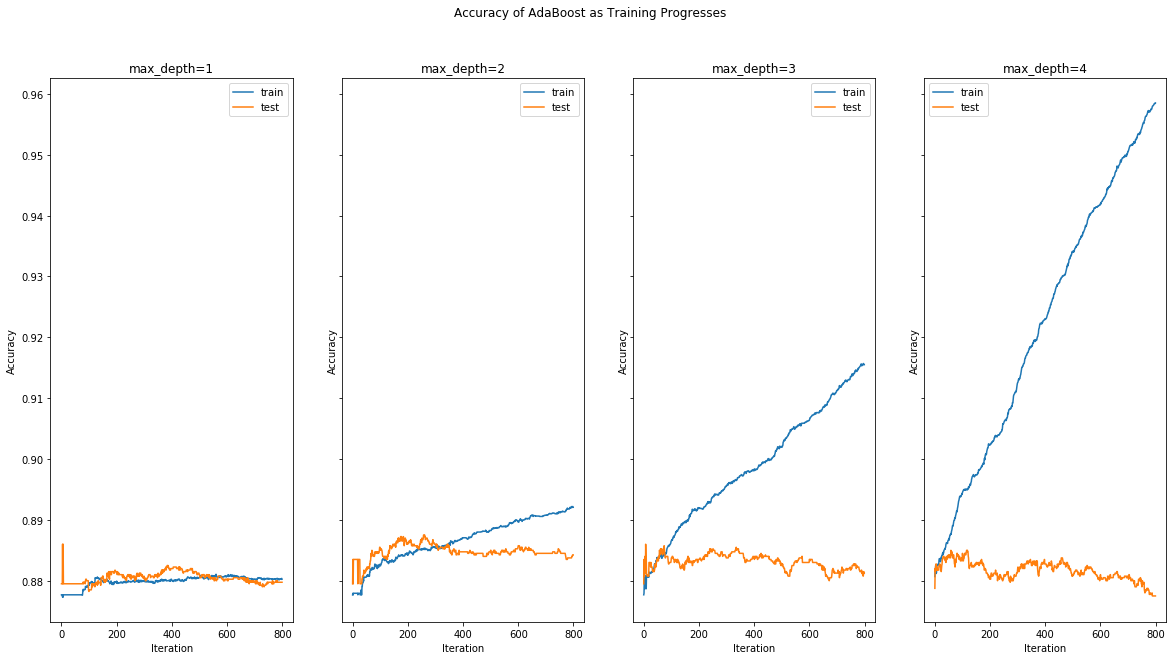

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(20,10), sharey=True)
for ax, depth in zip(axs, (1,2,3,4)):
    ax.plot(train_scores[depth], label='train')
    ax.plot(test_scores[depth], label='test')
    ax.set(xlabel='Iteration', ylabel='Accuracy', title=f"max_depth={depth}")
    ax.legend()
plt.suptitle("Accuracy of AdaBoost as Training Progresses");

In [27]:
best_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=250,
        learning_rate=.05).fit(X_train, y_train)
best_ada_train_score = best_ada.score(X_train, y_train)
best_ada_test_score = best_ada.score(X_test, y_test)



In [29]:

print('Classification accuracy on training set:', best_ada_train_score)
print('Classification accuracy on test set:', best_ada_test_score)


Max Depth: 2
# Estimators: 225
Classification accuracy on training set: 0.8848125
Classification accuracy on test set: 0.88575


### LOGIT

In [31]:
logit = LogisticRegressionCV( solver='liblinear', penalty='l1', multiclass='ovr', cv=5)
logit.fit(X_train, y_train)

log_y_train_pred = logit.predict(X_train) 
log_y_test_pred = logit.predict(X_test)

log_train_score = accuracy_score(y_train, log_y_train_pred)
log_test_score = accuracy_score(y_test, log_y_test_pred)

print('Penalty: LASSO')
print('Classification accuracy on training set:', log_train_score)
print('Classification accuracy on test set:', log_test_score)


Penalty: LASSO
Classification accuracy on training set: 0.871375
Classification accuracy on test set: 0.87725


# REGRESSION

In [34]:
# prepare for modeling
songs_df_clean2 = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(songs_df_clean2.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean2.Popularity, test_size = 0.2, 
                                                    random_state = 100)



In [ ]:
# standardization and get dummies for key and time signature

### SINGLE TREE

In [36]:
tree_reg = DecisionTreeRegressor(criterion='mse', splitter='best').fit(X_train_2, y_train_2)

tree_reg_train_score = tree_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', tree_reg_train_score)


tree_reg_test_score = tree_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', tree_reg_test_score)



R^2 on training set: 1.0
R^2 on test set: 0.9999959073751873


### BAGGING

In [40]:
bag_reg = BaggingRegressor(n_estimators=10, random_state=0).fit(X_train_2, y_train_2)

bag_reg_train_score = bag_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', bag_reg_train_score)

bag_reg_test_score = bag_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', bag_reg_test_score)


R^2 on training set: 0.9999993469427712
R^2 on test set: 0.9999982401713305


### RANDOM FOREST

In [44]:
rf_reg = RandomForestRegressor(n_estimators=100, criterion='mse').fit(X_train_2, y_train_2)

rf_reg_train_score = rf_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', rf_reg_train_score)

rf_reg_test_score = rf_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', rf_reg_test_score)




R^2 on training set: 0.9999997541851775
R^2 on test set: 0.9999979901119544


In [46]:
boost_reg = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100).fit(X_train_2, y_train_2)

boost_reg_train_score = boost_reg.score(X_train_2, y_train_2)
print('R^2 on training set:', boost_reg_train_score)

boost_reg_test_score = boost_reg.score(X_test_2, y_test_2)
print('R^2 on test set:', boost_reg_test_score)



R^2 on training set: 0.9999999949446787
R^2 on test set: 0.9999999937147233


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

In [ ]:

cid = '304f47a7973c446fa4cc490eaec6d061'
secret = 'f70927ac3cf14606b2aa54d4217ccf35'

client_credentials_manager = SpotifyClientCredentials(client_id = cid, client_secret = secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
sp.search(q = 'year:2019', type = 'track', limit = 50)['tracks']['items'][0]['album']['release_date']

In [ ]:

artist_name, track_name, track_id, popularity, release_date = [], [], [], [], []
for i in range(0, 10000, 50):
    track_results = sp.search(q = 'year:2019', type = 'track', limit = 50, offset = i)
    audio_features = sp.audio_features(track_id[i : i + 50])
    for i, t in enumerate(track_results['tracks']['items']):
        print(t['artists'][0]['name'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        release_date.append(t['album']['release_date'])

In [ ]:
acousticness, danceability, duration_ms, energy, instrumentalness = [], [], [], [], []
key, liveness, loudness, mode, speechiness = [], [], [], [], []
tempo, time_signature, valence = [], [], []

for i in range(0, len(track_id), 50):
    audio_features = sp.audio_features(track_id[i : i + 50])
    for track in audio_features:
        try:
            acousticness.append(track['acousticness'])
            danceability.append(track['danceability'])
            duration_ms.append(track['duration_ms'])
            energy.append(track['energy'])
            instrumentalness.append(track['instrumentalness'])
            key.append(track['key'])
            liveness.append(track['liveness'])
            loudness.append(track['loudness'])
            mode.append(track['mode'])
            speechiness.append(track['speechiness'])
            tempo.append(track['tempo'])
            time_signature.append(track['time_signature'])
            valence.append(track['valence'])
        except TypeError:
            acousticness.append(np.nan)
            danceability.append(np.nan)
            duration_ms.append(np.nan)
            energy.append(np.nan)
            instrumentalness.append(np.nan)
            key.append(np.nan)
            liveness.append(np.nan)
            loudness.append(np.nan)
            mode.append(np.nan)
            speechiness.append(np.nan)
            tempo.append(np.nan)
            time_signature.append(np.nan)
            valence.append(np.nan)

In [ ]:
data = {'Artist': artist_name, 'Track Name': track_name, 'Track ID': track_id, 'Popularity': popularity, 'Release Date': release_date,
       'Acousticness': acousticness, 'Danceability': danceability, 'Duration_ms': duration_ms, 
       'Energy': energy, 'Instrumentalness': instrumentalness, 'Key': key, 'Liveness': liveness,
       'Loudness': loudness, 'Mode': mode, 'Speechiness': speechiness, 'Tempo': tempo, 
       'Time Signature': time_signature, 'Valence': valence}
spotify_df = pd.DataFrame(data)
spotify_df = spotify_df[pd.notnull(spotify_df['Acousticness'])]
spotify_df.head()

In [ ]:
spotify_df.to_csv("data/new_music_test.csv", index=False)


In [ ]:
new_music = pd.read_csv('data/new_music_test.csv')

new_music['Release Date'] = pd.to_datetime(new_music['Release Date']) 

mask = (new_music['Release Date'] >= '2019-11-29') & (new_music['Release Date'] <= '2019-12-06')

new_music = new_music.loc[mask]

new_music.to_csv('data/new_music_test_clean.csv', index=False)

# NEW MUSIC TEST

In [2]:
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'Popularity'], 
                                                    songs_df_clean.Popularity, test_size = 0.2, 
                                                    random_state = 100)



In [ ]:
# regression
rf_fitted = RandomForestRegressor(n_estimators=100, criterion='mse').fit(X_train_2, y_train_2)


In [7]:
new_music_df = pd.read_csv('data/new_music_test_clean.csv')
new_friday_df = pd.read_csv('data/new_music_friday.csv')

new_music_clean_df = new_music_df.drop(columns=['Artist', 'Track Name', 'Track ID','Popularity', 'Release Date'])

In [9]:
new_music_preds = rf_fitted.predict(new_music_clean_df)

idx = np.argsort(-new_music_preds)[:100]

In [11]:
top99 = new_music_df[['Track Name']].values[idx]
topfriday = new_friday_df[['Track Name']].values

mask = np.isin(top99, topfriday)

top99[mask]


array(['PAID MY DUES', 'Good On You', 'Admit Defeat', 'Ay Ya Ya Ya',
       'Sorry Mama'], dtype=object)

In [12]:
songs_df = pd.read_csv('data/songs_all_decade_clean.csv')

songs_df['tophit'] = np.where(songs_df['Popularity'] > 60, 1, 0)


In [13]:
songs_df_clean = songs_df.drop(columns = ['Artist', 'Track Name', 'Track ID', 'Popularity'])

X_train, X_test, y_train, y_test = train_test_split(songs_df_clean.loc[:, songs_df_clean.columns != 'tophit'], 
                                                    songs_df_clean.tophit, test_size = 0.2, 
                                                    random_state = 100, stratify = songs_df_clean.tophit)

In [14]:
bag_fit = BaggingClassifier(n_estimators=50, random_state=0).fit(X_train,y_train)

In [15]:
new_music_df = pd.read_csv('data/new_music_test_clean.csv')
new_friday_df = pd.read_csv('data/new_music_friday.csv')

new_music_clean_df = new_music_df.drop(columns=['Artist', 'Track Name', 'Track ID','Popularity', 'Release Date'])

In [20]:
new_music_preds = bag_fit.predict(new_music_clean_df)

idx = np.where(new_music_preds==1)

pop = new_music_df[['Track Name']].values[idx]

topfriday = new_friday_df[['Track Name']].values

mask = np.isin(pop, topfriday)

pop[mask]


array(['PAID MY DUES', 'Inside Out', 'Texas Sun'], dtype=object)

---